In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
tf.__version__

'2.5.0'

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load the Quora question pairs dataset
quora = keras.utils.get_file(
    "quora_duplicate_questions.tsv",
    "https://drive.google.com/uc?id=0Bz8a_Dbh9QhbUDNpeUdjb0wxRms",
    cache_dir='./',
    cache_subdir=''
)

11788288/11784327 [==============================] - 2s 0us/step


In [9]:
class MultiheadAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super(MultiheadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        # Define the query, key, and value projection layers
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        
        # Define the output projection layer
        self.combine_heads = layers.Dense(embed_dim)
    
    def call(self, inputs):
        # Split the inputs into query, key, and value tensors
        query, key, value = inputs['query'], inputs['key'], inputs['value']
        
        # Project the query, key, and value tensors
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
        
        # Split the query, key, and value tensors into multiple heads
        query = tf.reshape(query, [-1, query.shape[1], self.num_heads, self.head_dim])
        query = tf.transpose(query, perm=[0, 2, 1, 3])
        key = tf.reshape(key, [-1, key.shape[1], self.num_heads, self.head_dim])
        key = tf.transpose(key, perm=[0, 2, 1, 3])
        value = tf.reshape(value, [-1, value.shape[1], self.num_heads, self.head_dim])
        value = tf.transpose(value, perm=[0, 2, 1, 3])
        
        # Compute the scaled dot product attention for each head
        attention_scores = tf.matmul(query, key, transpose_b=True)
        attention_scores /= tf.math.sqrt(tf.cast(self.head_dim, tf.float32))
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)
        attention_output = tf.matmul(attention_weights, value)
        
        # Merge the attention output back into a single tensor
        attention_output = tf.transpose(attention_output, perm=[0, 2, 1, 3])
        attention_output = tf.reshape(attention_output, [-1, attention_output.shape[1], self.embed_dim])
        attention_output = self.combine_heads(attention_output)
        
        return attention_output

In [11]:
class PositionalEncoding(layers.Layer):
    def __init__(self, sequence_length, embed_dim):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(sequence_length, embed_dim)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'sequence_length': self.sequence_length,
            'embed_dim': self.embed_dim,
        })
        return config

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

    def positional_encoding(self, sequence_length, embed_dim):
        position = np.arange(sequence_length)[:, np.newaxis]
        div_term = np.exp(np.arange(0, embed_dim, 2) * -(np.log(10000.0) / embed_dim))
        pos_enc = np.zeros((sequence_length, embed_dim))
        pos_enc[:, 0::2] = np.sin(position * div_term)
        pos_enc[:, 1::2] = np.cos(position * div_term)
        pos_enc = pos_enc[np.newaxis, ...]
        return tf.cast(pos_enc, dtype=tf.float32)

In [12]:
class Transformer(keras.Model):
    def __init__(self, embed_dim, num_heads, ff_dim, num_blocks, dropout_rate):
        super(Transformer, self).__init__()
        self.embedding = layers.Embedding(input_vocab_size, embed_dim)
        self.positional_encoding = PositionalEncoding(max_length, embed_dim)
        self.attention = [MultiheadAttention(embed_dim, num_heads) for _ in range(num_blocks)]
        self.ffn = [keras.Sequential([layers.Dense(ff_dim, activation='relu'),
                                      layers.Dense(embed_dim)]) for _ in range(num_blocks)]
        self.dropout = layers.Dropout(dropout_rate)
    
    def call(self, inputs):
        x = self.embedding(inputs)
        x = tf.cast(x, dtype=tf.float32)
        x *= tf.math.sqrt(tf.cast(embed_dim, tf.float32))
        x = self.positional_encoding(x)
        
        for i in range(num_blocks):
            # Multihead Attention
            attention_output = self.attention[i]({
                'query': x,
                'key': x,
                'value': x
            })
            attention_output = self.dropout(attention_output)
            x = x + attention_output
            
            # Feed-forward Neural Network
            ffn_output = self.ffn[i](x)
            ffn_output = self.dropout(ffn_output)
            x = x + ffn_output
            
        return x

In [59]:
# Define the model hyperparameters
embed_dim = 512
num_heads = 8
ff_dim = 2048
num_blocks = 6
dropout_rate = 0.1

# Define the input sequence length and vocabulary size
max_length = 100
input_vocab_size = 10000

# Define the model
transformer = Transformer(embed_dim, num_heads, ff_dim, num_blocks, dropout_rate)

# Define the inputs and outputs
inputs = keras.Input(shape=(max_length,))
outputs = transformer(inputs)
outputs = layers.GlobalAveragePooling1D()(outputs)
outputs = layers.Dense(max_length, activation='sigmoid')(outputs)

# Define the model
model = keras.Model(inputs=inputs, outputs=outputs)

In [60]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
transformer_3 (Transformer)  (None, 100, 512)          24022016  
_________________________________________________________________
global_average_pooling1d_3 ( (None, 512)               0         
_________________________________________________________________
dense_139 (Dense)            (None, 100)               51300     
Total params: 24,073,316
Trainable params: 24,073,316
Non-trainable params: 0
_________________________________________________________________


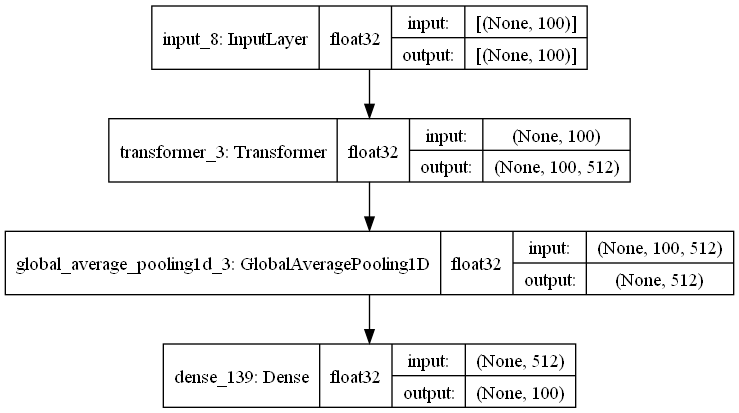

In [61]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_dtype=True,show_layer_names=True,show_shapes=True)

In [62]:
# # Compile and train the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.fit(train_inputs, train_outputs, validation_data=(val_inputs, val_outputs), epochs=10, batch_size=32)

In [63]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd

# Load the train.csv and test.csv files
train_data = pd.read_csv('ag_news_csv/train.csv')
test_data = pd.read_csv('ag_news_csv/test.csv')

# Combine the question and answer columns from train and test data
all_data = pd.concat([train_data['Question'], train_data['Answer'],
                      test_data['Question'], test_data['Answer']])

In [78]:
train_data = train_data.sample(5000,replace=True)
test_data = test_data.sample(5000,replace=True)

all_data = pd.concat([train_data['Question'], train_data['Answer'],
                      test_data['Question'], test_data['Answer']])

In [79]:
# Initialize the tokenizer
tokenizer = Tokenizer()

# Fit the tokenizer on the combined data
tokenizer.fit_on_texts(all_data)

# Convert text to sequences for train data
train_question_sequences = tokenizer.texts_to_sequences(train_data['Question'])
train_answer_sequences = tokenizer.texts_to_sequences(train_data['Answer'])

# Convert text to sequences for test data
test_question_sequences = tokenizer.texts_to_sequences(test_data['Question'])
test_answer_sequences = tokenizer.texts_to_sequences(test_data['Answer'])

# Pad sequences to a fixed length
max_length = 100  # adjust according to your data
train_question_sequences = pad_sequences(train_question_sequences, maxlen=max_length)
train_answer_sequences = pad_sequences(train_answer_sequences, maxlen=max_length)
test_question_sequences = pad_sequences(test_question_sequences, maxlen=max_length)
test_answer_sequences = pad_sequences(test_answer_sequences, maxlen=max_length)

# Print the tokenized and padded sequences
print("Tokenized and Padded Sequences for Train Data:")
print(train_question_sequences)
print(train_answer_sequences)
print("Tokenized and Padded Sequences for Test Data:")
print(test_question_sequences)
print(test_answer_sequences)

Tokenized and Padded Sequences for Train Data:
[[  0   0   0 ... 458   4 459]
 [  0   0   0 ... 458   4 459]
 [  0   0   0 ... 428   7  36]
 ...
 [  0   0   0 ... 356 357  18]
 [  0   0   0 ...  90  91  18]
 [  0   0   0 ... 458   4 459]]
[[  0   0   0 ... 473 474 475]
 [  0   0   0 ... 473 474 475]
 [  0   0   0 ... 440 441 107]
 ...
 [  0   0   0 ...  31   6  92]
 [  0   0   0 ... 339   8 340]
 [  0   0   0 ... 473 474 475]]
Tokenized and Padded Sequences for Test Data:
[[  0   0   0 ... 344 100 101]
 [  0   0   0 ...   5  64  65]
 [  0   0   0 ...  69  27  70]
 ...
 [  0   0   0 ...   3   6 114]
 [  0   0   0 ...   3   6 114]
 [  0   0   0 ... 134   8 135]]
[[  0   0   0 ... 109  28  93]
 [  0   0   0 ...   3   6 239]
 [  0   0   0 ...   1  66 258]
 ...
 [  0   0   0 ...  32  28 389]
 [  0   0   0 ...  32  28 389]
 [  0   0   0 ...  43  44 150]]


In [82]:
# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.fit(train_question_sequences, train_answer_sequences, validation_data=(test_question_sequences, test_answer_sequences), epochs=10, batch_size=32)

Epoch 1/10
 31/157 [====>.........................] - ETA: 6:01 - loss: nan - accuracy: 0.0000e+00

KeyboardInterrupt: 

In [70]:
text = tokenizer.texts_to_sequences("How are you doing today")

# Pad sequences to a fixed length
max_length = 100  # adjust according to your data
text = pad_sequences(text, maxlen=max_length)

In [76]:
model.predict(text).shape

(23, 100)